#### CTPN文字所在位置

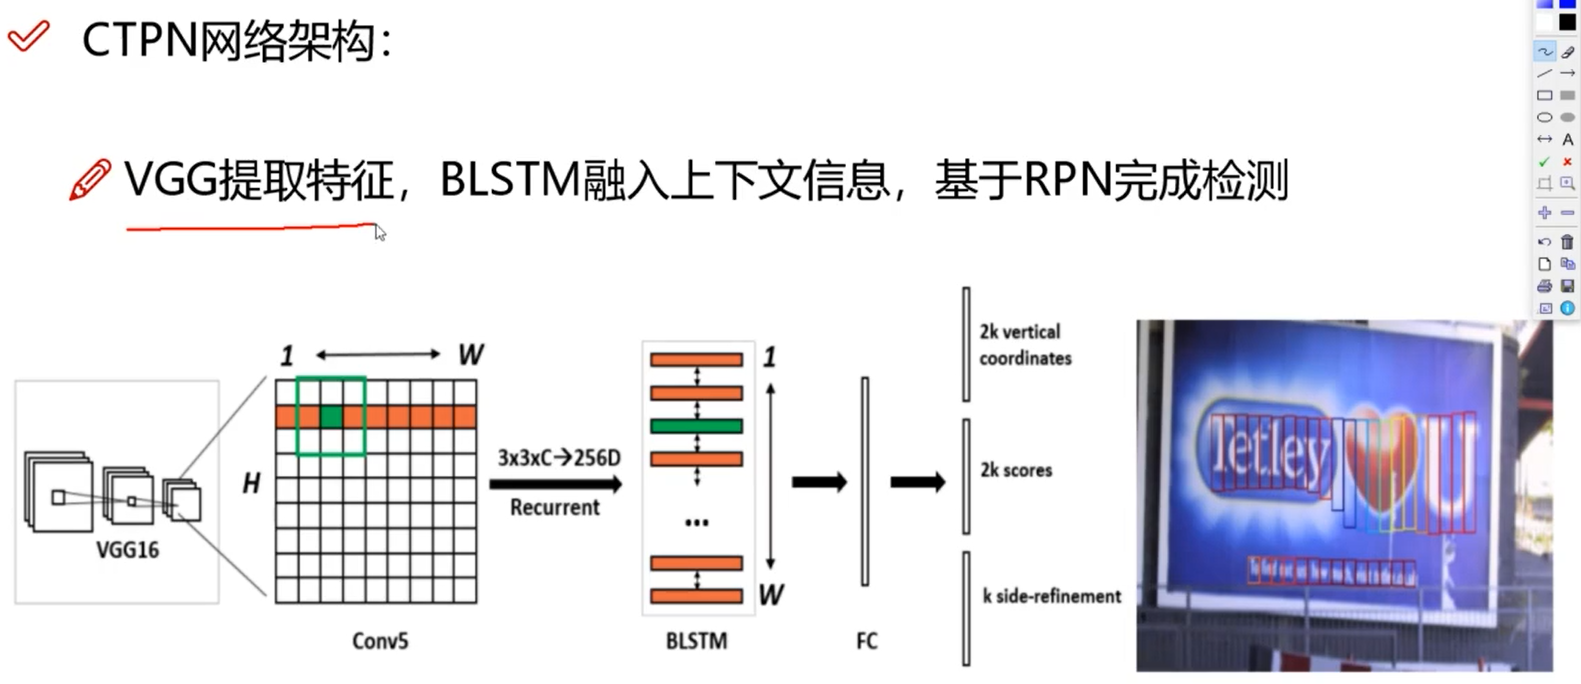

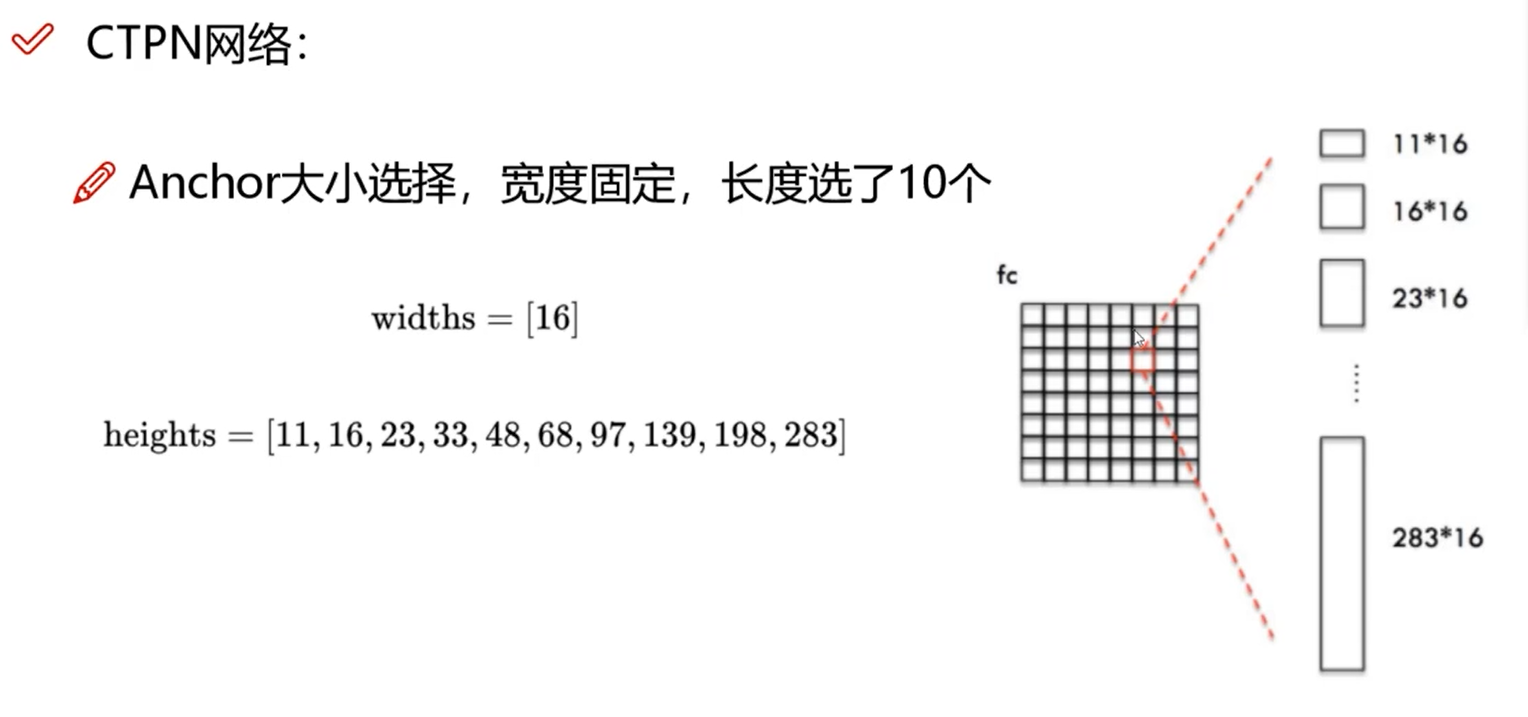

#### CRNN识别文字

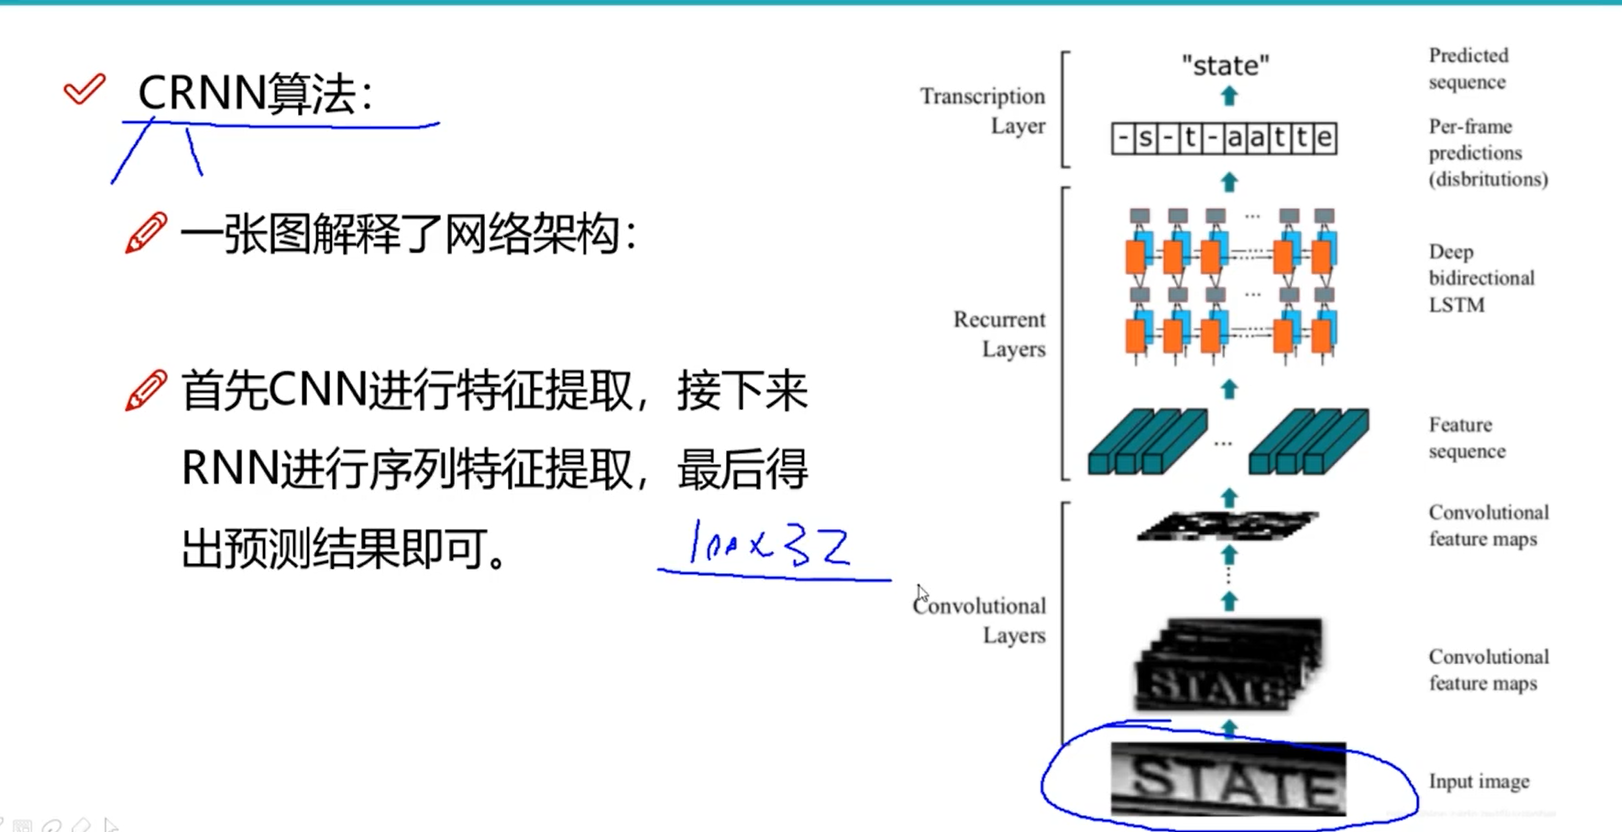

In [6]:
import os

# base_dir = 'path to dataset base dir'
base_dir = './images'
img_dir = os.path.join(base_dir, 'VOC2007_text_detection/JPEGImages')
xml_dir = os.path.join(base_dir, 'VOC2007_text_detection/Annotations')

icdar17_mlt_img_dir = './train_data/train_img/'
icdar17_mlt_gt_dir = './train_data/train_label/'
num_workers = 0
pretrained_weights = 'checkpoints/v3_ctpn_ep22_0.3801_0.0971_0.4773.pth'

anchor_scale = 16
IOU_NEGATIVE = 0.3
IOU_POSITIVE = 0.7
IOU_SELECT = 0.7

RPN_POSITIVE_NUM = 150
RPN_TOTAL_NUM = 300

# bgr can find from  here: https://github.com/fchollet/deep-learning-models/blob/master/imagenet_utils.py
IMAGE_MEAN = [123.68, 116.779, 103.939]
OHEM = True

checkpoints_dir = './checkpoints'
outputs = r'./logs'

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class RPN_REGR_Loss(nn.Module):
    def __init__(self, device, sigma=9.0):
        super(RPN_REGR_Loss, self).__init__()
        self.sigma = sigma
        self.device = device

    def forward(self, input, target):
        '''
        smooth L1 loss
        :param input:y_preds
        :param target: y_true
        :return:
        '''
        try:
            cls = target[0, :, 0]
            regr = target[0, :, 1:3]
            # apply regression to positive sample
            regr_keep = (cls == 1).nonzero()[:, 0]
            regr_true = regr[regr_keep]
            regr_pred = input[0][regr_keep]
            diff = torch.abs(regr_true - regr_pred)
            less_one = (diff<1.0/self.sigma).float()
            loss = less_one * 0.5 * diff ** 2 * self.sigma + torch.abs(1- less_one) * (diff - 0.5/self.sigma)
            loss = torch.sum(loss, 1)
            loss = torch.mean(loss) if loss.numel() > 0 else torch.tensor(0.0)
        except Exception as e:
            print('RPN_REGR_Loss Exception:', e)
            # print(input, target)
            loss = torch.tensor(0.0)

        return loss.to(self.device)


class RPN_CLS_Loss(nn.Module):
    def __init__(self,device):
        super(RPN_CLS_Loss, self).__init__()
        self.device = device
        self.L_cls = nn.CrossEntropyLoss(reduction='none')
        # self.L_regr = nn.SmoothL1Loss()
        # self.L_refi = nn.SmoothL1Loss()
        self.pos_neg_ratio = 3

    def forward(self, input, target):
        if config.OHEM:
            cls_gt = target[0][0]
            num_pos = 0
            loss_pos_sum = 0

            # print(len((cls_gt == 0).nonzero()),len((cls_gt == 1).nonzero()))

            if len((cls_gt == 1).nonzero())!=0:       # avoid num of pos sample is 0
                cls_pos = (cls_gt == 1).nonzero()[:, 0]
                gt_pos = cls_gt[cls_pos].long()
                cls_pred_pos = input[0][cls_pos]
                # print(cls_pred_pos.shape)
                loss_pos = self.L_cls(cls_pred_pos.view(-1, 2), gt_pos.view(-1))
                loss_pos_sum = loss_pos.sum()
                num_pos = len(loss_pos)

            cls_neg = (cls_gt == 0).nonzero()[:, 0]
            gt_neg = cls_gt[cls_neg].long()
            cls_pred_neg = input[0][cls_neg]

            loss_neg = self.L_cls(cls_pred_neg.view(-1, 2), gt_neg.view(-1))
            loss_neg_topK, _ = torch.topk(loss_neg, min(len(loss_neg), config.RPN_TOTAL_NUM-num_pos))
            loss_cls = loss_pos_sum+loss_neg_topK.sum()
            loss_cls = loss_cls/config.RPN_TOTAL_NUM
            return loss_cls.to(self.device)
        else:
            y_true = target[0][0]
            cls_keep = (y_true != -1).nonzero()[:, 0]
            cls_true = y_true[cls_keep].long()
            cls_pred = input[0][cls_keep]
            loss = F.nll_loss(F.log_softmax(cls_pred, dim=-1),
                              cls_true)  # original is sparse_softmax_cross_entropy_with_logits
            # loss = nn.BCEWithLogitsLoss()(cls_pred[:,0], cls_true.float())  # 18-12-8
            loss = torch.clamp(torch.mean(loss), 0, 10) if loss.numel() > 0 else torch.tensor(0.0)
            return loss.to(self.device)


class basic_conv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,
                 groups=1,
                 relu=True,
                 bn=True,
                 bias=True):
        super(basic_conv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU(inplace=True) if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x


class CTPN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = models.vgg16(pretrained=False)
        layers = list(base_model.features)[:-1]
        self.base_layers = nn.Sequential(*layers)  # block5_conv3 output
        self.rpn = basic_conv(512, 512, 3, 1, 1, bn=False)
        self.brnn = nn.GRU(512,128, bidirectional=True, batch_first=True)
        self.lstm_fc = basic_conv(256, 512, 1, 1, relu=True, bn=False)
        self.rpn_class = basic_conv(512, 10 * 2, 1, 1, relu=False, bn=False)
        self.rpn_regress = basic_conv(512, 10 * 2, 1, 1, relu=False, bn=False)

    def forward(self, x):
        #print ('1:',x.size())
        x = self.base_layers(x)
        #print ('2:',x.size())
        # rpn
        x = self.rpn(x)    #[b, c, h, w]
        #print ('3:',x.size())
        x1 = x.permute(0,2,3,1).contiguous()  # channels last   [b, h, w, c]
        #print ('4:',x1.size())
        b = x1.size()  # b, h, w, c
        x1 = x1.view(b[0]*b[1], b[2], b[3])
        #print ('5:',x1.size())
        x2, _ = self.brnn(x1)
        #print ('6:',x2.size())
        xsz = x.size()
        x3 = x2.view(xsz[0], xsz[2], xsz[3], 256)  # torch.Size([4, 20, 20, 256])
        #print ('7:',x3.size())
        x3 = x3.permute(0,3,1,2).contiguous()  # channels first [b, c, h, w]
        #print ('8:',x3.size())
        x3 = self.lstm_fc(x3)
        #print ('9:',x3.size())
        x = x3

        cls = self.rpn_class(x)
        #print ('10:',cls.size())
        regr = self.rpn_regress(x)
        #print ('11:',regr.size())
        cls = cls.permute(0,2,3,1).contiguous()
        regr = regr.permute(0,2,3,1).contiguous()

        cls = cls.view(cls.size(0), cls.size(1)*cls.size(2)*10, 2)
        #print ('12:',cls.size())
        regr = regr.view(regr.size(0), regr.size(1)*regr.size(2)*10, 2)
        #print ('13:',regr.size())

        return cls, regr

In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import torch
from torch.utils.data import DataLoader
from torch import optim
import numpy as np
import argparse


# dataset_download:https://rrc.cvc.uab.es/?ch=8&com=downloads
random_seed = 2019
torch.random.manual_seed(random_seed)
np.random.seed(random_seed)

epochs = 30
lr = 1e-3
resume_epoch = 0


def save_checkpoint(state, epoch, loss_cls, loss_regr, loss, ext='pth'):
    check_path = os.path.join(config.checkpoints_dir,
                              f'v3_ctpn_ep{epoch:02d}_'
                              f'{loss_cls:.4f}_{loss_regr:.4f}_{loss:.4f}.{ext}')

    try:
        torch.save(state, check_path)
    except BaseException as e:
        print(e)
        print('fail to save to {}'.format(check_path))
    print('saving to {}'.format(check_path))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


if __name__ == '__main__':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    checkpoints_weight = config.pretrained_weights
    print('exist pretrained ',os.path.exists(checkpoints_weight))
    if os.path.exists(checkpoints_weight):
        pretrained = False

    dataset = ICDARDataset(config.icdar17_mlt_img_dir, config.icdar17_mlt_gt_dir)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=config.num_workers)
    model = CTPN_Model()
    model.to(device)
    
    if os.path.exists(checkpoints_weight):
        print('using pretrained weight: {}'.format(checkpoints_weight))
        cc = torch.load(checkpoints_weight, map_location=device)
        model.load_state_dict(cc['model_state_dict'])
        resume_epoch = cc['epoch']
    else:
        model.apply(weights_init)

    params_to_uodate = model.parameters()
    optimizer = optim.SGD(params_to_uodate, lr=lr, momentum=0.9)
    
    critetion_cls = RPN_CLS_Loss(device)
    critetion_regr = RPN_REGR_Loss(device)
    
    best_loss_cls = 100
    best_loss_regr = 100
    best_loss = 100
    best_model = None
    epochs += resume_epoch
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(resume_epoch+1, epochs):
        print(f'Epoch {epoch}/{epochs}')
        print('#'*50)
        epoch_size = len(dataset) // 1
        model.train()
        epoch_loss_cls = 0
        epoch_loss_regr = 0
        epoch_loss = 0
        scheduler.step(epoch)
    
        for batch_i, (imgs, clss, regrs) in enumerate(dataloader):
            # print(imgs.shape)
            imgs = imgs.to(device)
            clss = clss.to(device)
            regrs = regrs.to(device)
    
            optimizer.zero_grad()
    
            out_cls, out_regr = model(imgs)
            loss_cls = critetion_cls(out_cls, clss)
            loss_regr = critetion_regr(out_regr, regrs)
    
            loss = loss_cls + loss_regr  # total loss
            loss.backward()
            optimizer.step()
    
            epoch_loss_cls += loss_cls.item()
            epoch_loss_regr += loss_regr.item()
            epoch_loss += loss.item()
            mmp = batch_i+1
    
            print(f'Ep:{epoch}/{epochs-1}--'
                  f'Batch:{batch_i}/{epoch_size}\n'
                  f'batch: loss_cls:{loss_cls.item():.4f}--loss_regr:{loss_regr.item():.4f}--loss:{loss.item():.4f}\n'
                  f'Epoch: loss_cls:{epoch_loss_cls/mmp:.4f}--loss_regr:{epoch_loss_regr/mmp:.4f}--'
                  f'loss:{epoch_loss/mmp:.4f}\n')
    
        epoch_loss_cls /= epoch_size
        epoch_loss_regr /= epoch_size
        epoch_loss /= epoch_size
        print(f'Epoch:{epoch}--{epoch_loss_cls:.4f}--{epoch_loss_regr:.4f}--{epoch_loss:.4f}')
        if best_loss_cls > epoch_loss_cls or best_loss_regr > epoch_loss_regr or best_loss > epoch_loss:
            best_loss = epoch_loss
            best_loss_regr = epoch_loss_regr
            best_loss_cls = epoch_loss_cls
            best_model = model
            save_checkpoint({'model_state_dict': best_model.state_dict(),
                             'epoch': epoch},
                            epoch,
                            best_loss_cls,
                            best_loss_regr,
                            best_loss)
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

NameError: name 'config' is not defined

In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import cv2
from torch.utils.data import Dataset
import torch
from config import IMAGE_MEAN
from ctpn_utils import cal_rpn


def readxml(path):
    gtboxes = []
    imgfile = ''
    xml = ET.parse(path)
    for elem in xml.iter():
        if 'filename' in elem.tag:
            imgfile = elem.text
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'bndbox' in attr.tag:
                    xmin = int(round(float(attr.find('xmin').text)))
                    ymin = int(round(float(attr.find('ymin').text)))
                    xmax = int(round(float(attr.find('xmax').text)))
                    ymax = int(round(float(attr.find('ymax').text)))

                    gtboxes.append((xmin, ymin, xmax, ymax))

    return np.array(gtboxes), imgfile


# for ctpn text detection
class VOCDataset(Dataset):
    def __init__(self,
                 datadir,
                 labelsdir):
        '''

        :param txtfile: image name list text file
        :param datadir: image's directory
        :param labelsdir: annotations' directory
        '''
        if not os.path.isdir(datadir):
            raise Exception('[ERROR] {} is not a directory'.format(datadir))
        if not os.path.isdir(labelsdir):
            raise Exception('[ERROR] {} is not a directory'.format(labelsdir))

        self.datadir = datadir
        self.img_names = os.listdir(self.datadir)
        self.labelsdir = labelsdir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.datadir, img_name)
        print(img_path)
        xml_path = os.path.join(self.labelsdir, img_name.replace('.jpg', '.xml'))
        gtbox, _ = readxml(xml_path)
        img = cv2.imread(img_path)
        h, w, c = img.shape

        # clip image
        if np.random.randint(2) == 1:
            img = img[:, ::-1, :]
            newx1 = w - gtbox[:, 2] - 1
            newx2 = w - gtbox[:, 0] - 1
            gtbox[:, 0] = newx1
            gtbox[:, 2] = newx2

        [cls, regr], _ = cal_rpn((h, w), (int(h / 16), int(w / 16)), 16, gtbox)

        m_img = img - IMAGE_MEAN

        regr = np.hstack([cls.reshape(cls.shape[0], 1), regr])

        cls = np.expand_dims(cls, axis=0)

        # transform to torch tensor
        m_img = torch.from_numpy(m_img.transpose([2, 0, 1])).float()
        cls = torch.from_numpy(cls).float()
        regr = torch.from_numpy(regr).float()

        return m_img, cls, regr

class ICDARDataset(Dataset):
    def __init__(self,
                 datadir,
                 labelsdir):
        '''

        :param txtfile: image name list text file
        :param datadir: image's directory
        :param labelsdir: annotations' directory
        '''
        if not os.path.isdir(datadir):
            raise Exception('[ERROR] {} is not a directory'.format(datadir))
        if not os.path.isdir(labelsdir):
            raise Exception('[ERROR] {} is not a directory'.format(labelsdir))

        self.datadir = datadir
        self.img_names = os.listdir(self.datadir)
        self.labelsdir = labelsdir

    def __len__(self):
        return len(self.img_names)

    def box_transfer(self,coor_lists,rescale_fac = 1.0):
        gtboxes = []
        for coor_list in coor_lists:
            coors_x = [int(coor_list[2*i]) for i in range(4)]
            coors_y = [int(coor_list[2*i+1]) for i in range(4)]
            xmin = min(coors_x)
            xmax = max(coors_x)
            ymin = min(coors_y)
            ymax = max(coors_y)
            if rescale_fac>1.0:
                xmin = int(xmin / rescale_fac)
                xmax = int(xmax / rescale_fac)
                ymin = int(ymin / rescale_fac)
                ymax = int(ymax / rescale_fac)
            gtboxes.append((xmin, ymin, xmax, ymax))
        return np.array(gtboxes)

    def box_transfer_v2(self,coor_lists,rescale_fac = 1.0):
        gtboxes = []
        for coor_list in coor_lists:
            coors_x = [int(coor_list[2 * i]) for i in range(4)]
            coors_y = [int(coor_list[2 * i + 1]) for i in range(4)]
            xmin = min(coors_x)
            xmax = max(coors_x)
            ymin = min(coors_y)
            ymax = max(coors_y)
            if rescale_fac > 1.0:
                xmin = int(xmin / rescale_fac)
                xmax = int(xmax / rescale_fac)
                ymin = int(ymin / rescale_fac)
                ymax = int(ymax / rescale_fac)
            prev = xmin
            for i in range(xmin // 16 + 1, xmax // 16 + 1):
                next = 16*i-0.5
                gtboxes.append((prev, ymin, next, ymax))
                prev = next
            gtboxes.append((prev, ymin, xmax, ymax))
        return np.array(gtboxes)

    def parse_gtfile(self,gt_path,rescale_fac = 1.0):
        coor_lists = list()
        with open(gt_path,encoding='UTF-8') as f:
            content = f.readlines()
            for line in content:
                coor_list = line.split(',')[:8]
                if len(coor_list)==8:
                    coor_lists.append(coor_list)
        return self.box_transfer_v2(coor_lists,rescale_fac)

    def draw_boxes(self,img,cls,base_anchors,gt_box):
        for i in range(len(cls)):
            if cls[i]==1:
                pt1 = (int(base_anchors[i][0]),int(base_anchors[i][1]))
                pt2 = (int(base_anchors[i][2]),int(base_anchors[i][3]))
                img = cv2.rectangle(img,pt1,pt2,(200,100,100))
        for i in range(gt_box.shape[0]):
            pt1 = (int(gt_box[i][0]),int(gt_box[i][1]))
            pt2 = (int(gt_box[i][2]),int(gt_box[i][3]))
            img = cv2.rectangle(img, pt1, pt2, (100, 200, 100))
        return img

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.datadir, img_name)
        # print(img_path)
        img = cv2.imread(img_path)
        #####for read error, use default image#####
        if img is None:
            print(img_path)
            with open('error_imgs.txt','a') as f:
                f.write('{}\n'.format(img_path))
            img_name = 'img_2647.jpg'
            img_path = os.path.join(self.datadir, img_name)
            img = cv2.imread(img_path)

        #####for read error, use default image#####

        h, w, c = img.shape
        rescale_fac = max(h, w) / 1600
        if rescale_fac>1.0:
            h = int(h/rescale_fac)
            w = int(w/rescale_fac)
            img = cv2.resize(img,(w,h))

        gt_path = os.path.join(self.labelsdir, 'gt_'+img_name.split('.')[0]+'.txt')
        gtbox = self.parse_gtfile(gt_path,rescale_fac)

        # clip image
        if np.random.randint(2) == 1:
            img = img[:, ::-1, :]
            newx1 = w - gtbox[:, 2] - 1
            newx2 = w - gtbox[:, 0] - 1
            gtbox[:, 0] = newx1
            gtbox[:, 2] = newx2

        [cls, regr], base_anchors = cal_rpn((h, w), (int(h / 16), int(w / 16)), 16, gtbox)
        # debug_img = self.draw_boxes(img.copy(),cls,base_anchors,gtbox)
        # cv2.imwrite('debug/{}'.format(img_name),debug_img)
        m_img = img - IMAGE_MEAN

        regr = np.hstack([cls.reshape(cls.shape[0], 1), regr])

        cls = np.expand_dims(cls, axis=0)

        # transform to torch tensor
        m_img = torch.from_numpy(m_img.transpose([2, 0, 1])).float()
        cls = torch.from_numpy(cls).float()
        regr = torch.from_numpy(regr).float()

        return m_img, cls, regr

if __name__ == '__main__':
    xmin = 15
    xmax = 95
    for i in range(xmin//16+1,xmax//16+1):
        print(16*i-0.5)